## OmniFold

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', size=20)

In [3]:
datasets = np.load('rawdata.npz')
datasets.files

['arr_0',
 'arr_1',
 'arr_2',
 'arr_3',
 'arr_4',
 'arr_5',
 'arr_6',
 'arr_7',
 'arr_8',
 'arr_9',
 'arr_10',
 'arr_11']

In [4]:
pT_true, pT_true_alt, pT_reco, pT_reco_alt, m_true, m_true_alt, m_reco, m_reco_alt, q_true, q_true_alt, q_reco, q_reco_alt = (datasets[datasets.files[i]] for i in range(12))

## Set up the binning 

In [5]:
#For the binning, make it so we have 50% in each bin growing from the low side
binvals = [100]
i = 0
while binvals[-1] < 500:
    for binhigh in range(binvals[i]+1,1000):
        purity = len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)*(pT_reco > binvals[i])*(pT_reco < binhigh)]) / len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)])
        if (purity > 0.5**0.5):
            print(binhigh,purity)
            i+=1
            binvals+=[binhigh]
            break

134 0.7082022305322636
175 0.7078793549875664
224 0.7075873586035227
285 0.7093473767703654
361 0.7091339517997708
458 0.7075367685298829
583 0.7074240849786398


In [6]:
#Next, let's construct the response matrix.

pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1

#alt

pTbin_truth_alt = np.clip(np.digitize(pT_true_alt,binvals),1,len(binvals)-1)-1
pTbin_reco_alt = np.clip(np.digitize(pT_reco_alt,binvals),1,len(binvals)-1)-1

mbin_truth = np.clip(np.digitize(m_true,binvals),1,len(binvals)-1)-1
mbin_reco = np.clip(np.digitize(m_reco,binvals),1,len(binvals)-1)-1

#alt

mbin_truth_alt = np.clip(np.digitize(m_true_alt,binvals),1,len(binvals)-1)-1
mbin_reco_alt = np.clip(np.digitize(m_reco_alt,binvals),1,len(binvals)-1)-1

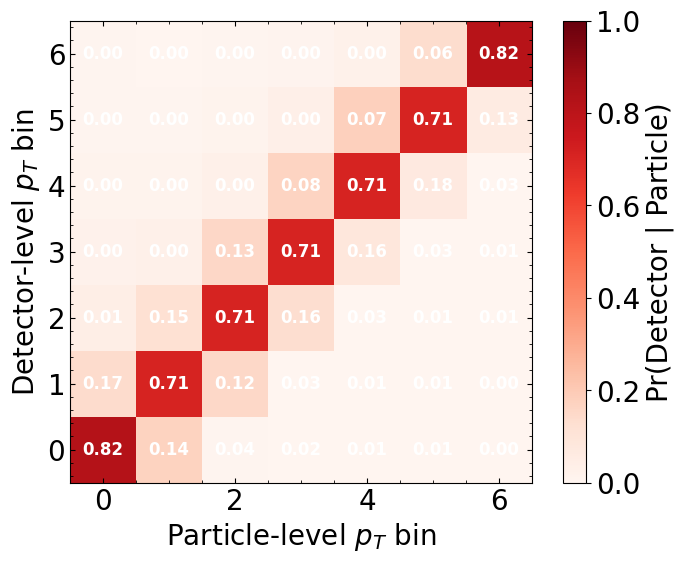

In [6]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
H_pT, xedges, yedges = np.histogram2d(pTbin_truth,pTbin_reco,bins=[range(len(binvals)),range(len(binvals))])
H_norm_pT = H_pT / H_pT.sum(axis=1, keepdims=True)
plt.imshow(H_norm_pT,origin='lower',cmap="Reds",vmin = 0,vmax = 1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pr(Detector | Particle)') 
plt.xlabel("Particle-level $p_{T}$ bin",fontsize=20)
plt.ylabel("Detector-level $p_{T}$ bin",fontsize=20)

for i in range(len(binvals)-1):
    for j2 in range(len(binvals)-1):
        plt.text(j2,i, "%0.2f" % H_norm_pT.T[i,j2], 
                color="w", ha="center", va="center", fontweight="bold",fontsize=12)
fig.savefig('figures/RsponsepT.pdf',bbox_inches='tight')

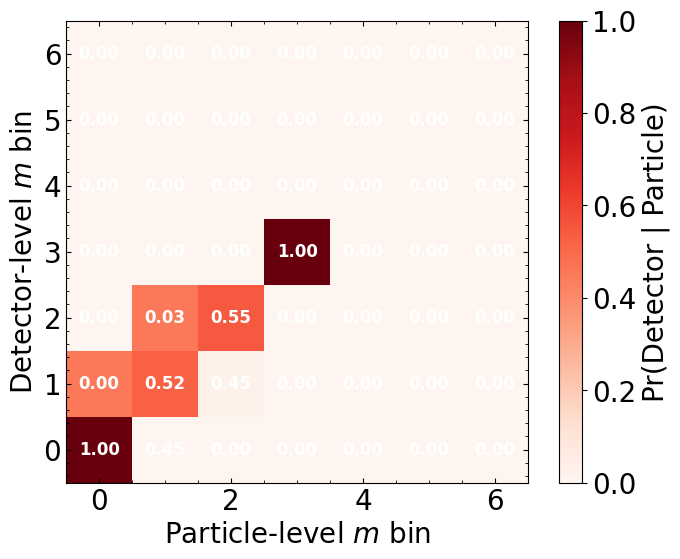

In [7]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
H_m, xedges, yedges = np.histogram2d(mbin_truth,mbin_reco,bins=[range(len(binvals)),range(len(binvals))])
H_norm_m = H_m / (H_m.sum(axis=1, keepdims=True) + 1e-6)
plt.imshow(H_norm_m,origin='lower',cmap="Reds",vmin = 0,vmax = 1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pr(Detector | Particle)') 
plt.xlabel("Particle-level $m$ bin",fontsize=20)
plt.ylabel("Detector-level $m$ bin",fontsize=20)

for i in range(len(binvals)-1):
    for j2 in range(len(binvals)-1):
        plt.text(j2,i, "%0.2f" % H_norm_m.T[i,j2], 
                color="w", ha="center", va="center", fontweight="bold",fontsize=12)
fig.savefig('figures/Rsponsem.pdf',bbox_inches='tight')

## IBU

In [8]:
def IBU(T,D,R,n):
    phis = [T]
    for i in range(n):
        m = R * phis[-1]
        m /= (m.sum(axis=1)[:,np.newaxis] + 10**-50)
        phis.append(np.dot(m.T, D))
    return phis[-1]

In [9]:
T_p = np.sum(H_pT,axis=1)
D_p = np.sum(H_pT,axis=0)
IBU(T_p,D_p,H_norm_pT.T,1)

array([ 71857., 156028., 317371., 262234., 119543.,  48071.,  24896.])

In [10]:
T_m = np.sum(H_m,axis=1)
D_m = np.sum(H_m,axis=0)
IBU(T_m,D_m,H_norm_m.T,1)

array([9.99900000e+05, 7.49999997e+01, 2.19999996e+01, 3.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

## Omnifold

In [79]:
from unfold import *

import os
os.environ['CUDA_VISIBLE_DEVICES']="1"

import tensorflow as tf
import tensorflow.keras.backend as K
tf.random.set_seed(1234)
np.random.seed(1234)

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [80]:
iterations = 5
dims = 2

In [82]:
weights, models, history = multifold(dims, iterations, np.c_[pT_true/100.-2,q_true/10.-2], 
                                     np.c_[pT_reco/100.-2,q_reco/10.-2], 
                                     np.c_[pT_reco_alt/100.-2,q_reco_alt/10.-2], 
                                     verbose=1)

ITERATION: 1
STEP 1...
Epoch 1/1000
7500/7500 [==============================] - 6s 714us/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.7118
Epoch 2/1000
7500/7500 [==============================] - 6s 741us/step - loss: 0.6931 - accuracy: 0.5311 - val_loss: 0.6932 - val_accuracy: 0.7414
Epoch 3/1000
7500/7500 [==============================] - 6s 759us/step - loss: 0.6931 - accuracy: 0.5315 - val_loss: 0.6932 - val_accuracy: 0.6787
Epoch 4/1000
7500/7500 [==============================] - 5s 657us/step - loss: 0.6931 - accuracy: 0.5526 - val_loss: 0.6931 - val_accuracy: 0.7227
Epoch 5/1000
7500/7500 [==============================] - 5s 652us/step - loss: 0.6931 - accuracy: 0.5606 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 6/1000
7500/7500 [==============================] - 5s 649us/step - loss: 0.6931 - accuracy: 0.5436 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 7/1000
7500/7500 [==============================] - 5s 652us/step - loss: 0.6931 - 

In [83]:
weights.shape

(5, 2, 1000000)

In [85]:
np.save('weights_omnifold_q', weights)

In [14]:
pT_true = datasets['Pythia26']['gen_jets'][:,0]
pT_reco = datasets['Pythia26']['sim_jets'][:,0]

pT_true_alt = datasets['Herwig']['gen_jets'][:,0]
pT_reco_alt = datasets['Herwig']['sim_jets'][:,0]

features = {}

features["m","rec","nom"] = np.array(datasets['Pythia26']['sim_jets'][:,3])
features["m","tru","nom"] = np.array(datasets['Pythia26']['gen_jets'][:,3])
features["m","rec","alt"] = np.array(datasets['Herwig']['sim_jets'][:,3])
features["m","tru","alt"] = np.array(datasets['Herwig']['gen_jets'][:,3])

# features["w","rec","nom"] = np.array(datasets['Pythia26']['sim_widths'])
# features["w","tru","nom"] = np.array(datasets['Pythia26']['gen_widths'])
# features["w","rec","alt"] = np.array(datasets['Herwig']['sim_widths'])
# features["w","tru","alt"] = np.array(datasets['Herwig']['gen_widths'])

# features["q","rec","nom"] = np.array(datasets['Pythia26']['sim_charge'])
# features["q","tru","nom"] = np.array(datasets['Pythia26']['gen_charge'])
# features["q","rec","alt"] = np.array(datasets['Herwig']['sim_charge'])
# features["q","tru","alt"] = np.array(datasets['Herwig']['gen_charge'])

# features["r","rec","nom"] = np.array(datasets['Pythia26']['sim_pTcharge'])
# features["r","tru","nom"] = np.array(datasets['Pythia26']['gen_pTcharge'])
# features["r","rec","alt"] = np.array(datasets['Herwig']['sim_pTcharge'])
# features["r","tru","alt"] = np.array(datasets['Herwig']['gen_pTcharge'])

maxvalues = {}

maxvalues['m'] = 200
# maxvalues['w'] = 0.7
# maxvalues['q'] = 0.5
# maxvalues['r'] = 1

minvalues = {}

minvalues['m'] = 0
# minvalues['w'] = 0
# minvalues['q'] = -0.5
# minvalues['r'] = 0

omnifolded = {}
#omnifolded['r'] = weightsR[-1,1]
#omnifolded['q'] = weightsQ[-1,1]
#omnifolded['w'] = weightsW[-1,1]
omnifolded['m'] = weights_omnifold[-1,1]

3
3
3
3
3
4
11


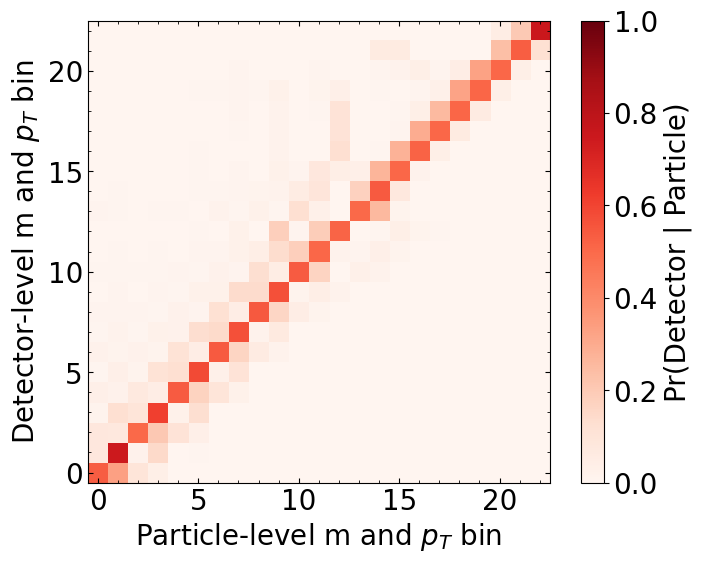

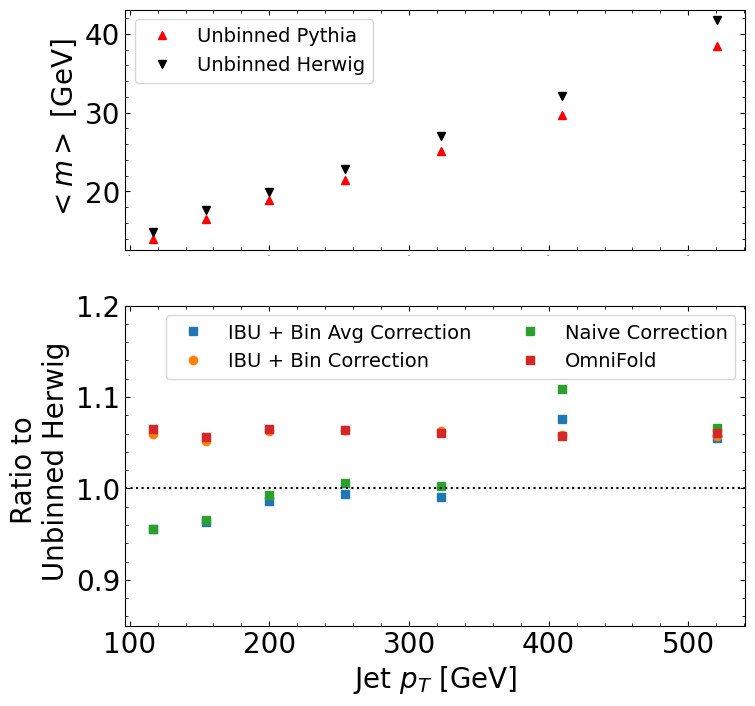

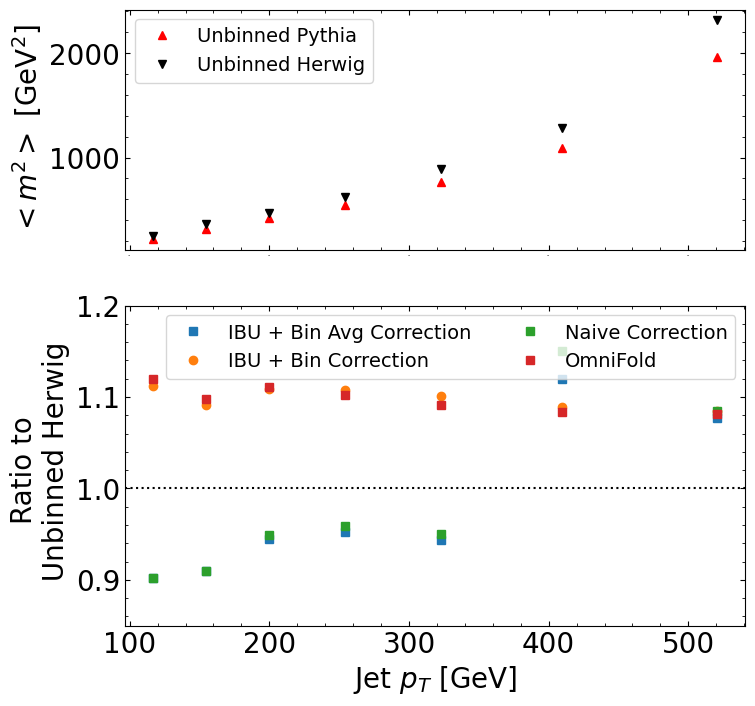

In [15]:
binvalsObs = {}
for obs in ['m']:
    binvalsObs[obs] = {}
    pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
    pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1
    xt = features[obs,"tru","nom"]
    xr = features[obs,"rec","nom"]
    for ii in range(len(binvals)-1):
        binvalsObs[obs][ii] = [minvalues[obs]]
        i = 0
        disttotal = 0.
        breakloop = True
        while len(binvalsObs[obs][ii]) < 15 and binvalsObs[obs][ii][-1] < maxvalues[obs] and breakloop:
            mycount = 0
            for binhigh in np.linspace(binvalsObs[obs][ii][i]+0.01,maxvalues[obs],100):
                mycount+=1
                purity = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xt[(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)]))
                distamount = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xr[(pTbin_reco==ii)*(pTbin_truth==ii)]))
                if (purity > 0.5):
                    i+=1
                    disttotal += distamount
                    binvalsObs[obs][ii]+=[binhigh]
                    #print("  ",binhigh,purity,disttotal,distamount)
                    break
                if (mycount==99):
                    breakloop = False
                    #binvalsObs[obs][ii]+=[rmax]

        print(len(binvalsObs[obs][ii])) #,binvalsObs[obs][ii])
        pass
    
    #Next, let's construct the response matrix.

    pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
    pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1

    xbin_truth_all = np.array([np.clip(np.digitize(xt,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
    xbin_reco_all = np.array([np.clip(np.digitize(xr,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
    xbin_truth_all = xbin_truth_all.T
    xbin_reco_all = xbin_reco_all.T

    xbin_truth = np.array([xbin_truth_all[i][pTbin_truth[i]] for i in range(len(pTbin_truth))])
    xbin_reco = np.array([xbin_reco_all[i][pTbin_reco[i]] for i in range(len(pTbin_reco))])

    ###
    bin2_truth = []
    for i in range(len(pTbin_truth)):
        mybin = 0
        for i2 in range(0,pTbin_truth[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_truth+=[mybin+xbin_truth[i]]

    bin2_reco = []
    for i in range(len(pTbin_reco)):
        mybin = 0
        for i2 in range(0,pTbin_reco[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_reco+=[mybin+xbin_reco[i]]

    #alt
    xta = features[obs,"tru","alt"]
    xra = features[obs,"rec","alt"]

    pTbin_truth_alt = np.clip(np.digitize(pT_true_alt,binvals),1,len(binvals)-1)-1
    pTbin_reco_alt = np.clip(np.digitize(pT_reco_alt,binvals),1,len(binvals)-1)-1

    xbin_truth_all_alt = np.array([np.clip(np.digitize(xta,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
    xbin_reco_all_alt = np.array([np.clip(np.digitize(xra,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
    xbin_truth_all_alt = xbin_truth_all_alt.T
    xbin_reco_all_alt = xbin_reco_all_alt.T

    xbin_truth_alt = np.array([xbin_truth_all_alt[i][pTbin_truth_alt[i]] for i in range(len(pTbin_truth_alt))])
    xbin_reco_alt = np.array([xbin_reco_all_alt[i][pTbin_reco_alt[i]] for i in range(len(pTbin_reco_alt))])

    bin2_truth_alt = []
    for i in range(len(pTbin_truth_alt)):
        mybin = 0
        for i2 in range(0,pTbin_truth_alt[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_truth_alt+=[mybin+xbin_truth_alt[i]]

    bin2_reco_alt = []
    for i in range(len(pTbin_reco_alt)):
        mybin = 0
        for i2 in range(0,pTbin_reco_alt[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_reco_alt+=[mybin+xbin_reco_alt[i]]

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    H, xedges, yedges = np.histogram2d(bin2_truth,bin2_reco,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
    H_alt, xedges, yedges = np.histogram2d(bin2_truth_alt,bin2_reco_alt,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
    H_norm = H / H.sum(axis=1, keepdims=True)
    plt.imshow(H_norm,origin='lower',cmap="Reds",vmin = 0,vmax = 1)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Pr(Detector | Particle)')

    plt.xlabel("Particle-level "+obs+" and $p_{T}$ bin",fontsize=20)
    plt.ylabel("Detector-level "+obs+" and $p_{T}$ bin",fontsize=20)
    fig.savefig('figures/response'+obs+'.pdf',bbox_inches='tight')
    
    #IBU
    T = np.sum(H,axis=1)
    D = np.sum(H,axis=0)
    D_alt = np.sum(H_alt,axis=0)
    T_alt = np.sum(H_alt,axis=1)
    ibu = IBU(T,D_alt,H_norm.T,10)
    #ibu = IBU(T,D,H_norm.T,10)
    
    for moment in [1,2]:

        #Unbinned
        means_unbinnedx = np.array([np.mean(xt[pTbin_truth==i]**moment) for i in range(7)])
        means_unbinnedx_alt = np.array([np.mean(xta[pTbin_truth_alt==i]**moment) for i in range(7)])

        means_unbinnedx_reco = np.array([np.mean(xr[pTbin_reco==i]**moment) for i in range(7)])
        means_unbinnedx_reco_alt = np.array([np.mean(xra[pTbin_reco_alt==i]**moment) for i in range(7)])
        means_unbinnedx_omnifold_alt = np.array([np.average(xt[pTbin_truth==i]**moment,weights=omnifolded[obs][pTbin_truth==i]) for i in range(7)])

        #Various corrections
        means_binnedx = []
        means_binnedx_alt = []
        means_binnedx_alt_corrected = []
        for i in range(7):

            mybin = 0
            for i2 in range(0,i):
                mybin += len(binvalsObs[obs][i2])-1

            ibu_i = [ibu[mybin+j] for j in range(len(binvalsObs[obs][i])-1)]

            x_centers = 0.5*(np.array(binvalsObs[obs][i][0:-1])+np.array(binvalsObs[obs][i][1:]))
            xvals = [len(xt[(pTbin_truth==i)*(xbin_truth==j)]) for j in range(len(binvalsObs[obs][i])-1)]
            xvals_alt = [len(xta[(pTbin_truth_alt==i)*(xbin_truth_alt==j)]) for j in range(len(binvalsObs[obs][i])-1)]
            means_binnedx += [np.sum(x_centers**moment*xvals)/np.sum(xvals)]
            means_binnedx_alt += [np.sum(x_centers**moment*ibu_i)/np.sum(ibu_i)]

            #Try a per-bin correction
            xiavg = []
            for j in range(len(binvalsObs[obs][i])-1):
                xiavg+=[np.mean(xt[(pTbin_truth==i)*(xbin_truth==j)]**moment)]
            xiavg = np.array(xiavg)
            #print(np.mean(xt[(pTbin_truth==i)]),np.sum(xiavg*ibu_i)/np.sum(ibu_i))
            means_binnedx_alt_corrected += [np.sum(xiavg*ibu_i)/np.sum(ibu_i)]

        means_binnedx = np.array(means_binnedx)
        means_binnedx_alt = np.array(means_binnedx_alt)
        means_binnedx_alt_corrected = np.array(means_binnedx_alt_corrected)

        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,4]) 
        ax0 = plt.subplot(gs[0])
        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        ax0.minorticks_on()

        plt.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_unbinnedx,marker='^',ls="",label="Unbinned Pythia",color='red')
        plt.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_unbinnedx_alt,marker='v',ls="",label="Unbinned Herwig",color='black')
        #plt.ylim([0.05,0.25])

        plt.legend(frameon=True,fontsize=14)
        if (moment==1):
            plt.ylabel(r'$< '+obs+' >$',fontsize=20)
        else:
            plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$',fontsize=20)
        if (obs=='m'):
            if (moment==1):
                plt.ylabel(r'$< '+obs+' >$ [GeV]',fontsize=20)
            else:
                plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$ [GeV$^'+str(moment)+'$]',fontsize=20)
            
        ax1 = plt.subplot(gs[1])
        ax1.yaxis.set_ticks_position('both')
        ax1.xaxis.set_ticks_position('both')
        ax1.tick_params(direction="in",which="both")
        ax1.minorticks_on()

        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_binnedx_alt_corrected/means_unbinnedx_alt,marker='s',ls="",label="IBU + Bin Avg Correction")
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),(means_unbinnedx_reco_alt*means_unbinnedx/means_unbinnedx_reco)/means_unbinnedx_alt,marker='o',ls="",label="IBU + Bin Correction")
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),(means_binnedx_alt*means_unbinnedx/means_binnedx)/means_unbinnedx_alt,marker='s',ls="",label="Naive Correction")
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_unbinnedx_omnifold_alt/means_unbinnedx_alt,marker='s',ls="",label="OmniFold")
        ax1.set_xlabel("Jet $p_{T}$ [GeV]",fontsize=20)
        ax1.axhline(1.,ls=":",color="black")
        ax1.set_ylim([0.85,1.2])
        ax1.legend(frameon=True,ncol=2,fontsize=14)
        plt.ylabel('Ratio to \n Unbinned Herwig',fontsize=20)
        fig.savefig('figures/moment'+str(moment)+"_"+obs+'_v_pT.pdf',bbox_inches='tight')

## Moment Unfolding

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization

In [8]:
normalize = True
data_size = 10**6
n_moments = 2
mylambda = []

In [9]:
x_gen = q_true_alt #gen = particle level
x_sim = q_reco_alt #sim = detector level
x_truth = q_true
x_data = q_reco

p_gen = pT_true_alt #gen = particle level
p_sim = pT_reco_alt #sim = detector level
p_truth = pT_true
p_data = pT_reco


if normalize:   
    xm = np.mean(x_truth)
    xs = np.std(x_truth)
    pm = np.mean(p_truth)
    ps = np.mean(p_truth)
    
    x_gen = (x_gen - xm)/xs
    x_sim = (x_sim - xm)/xs
    x_truth = (x_truth - xm)/xs
    x_data = (x_data - xm)/xs
    
    p_gen = (p_gen - pm)/ps
    p_sim = (p_sim - pm)/ps
    p_truth = (p_truth - pm)/ps
    p_data = (p_data - pm)/ps

In [14]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.m0 = self.add_weight(name='m0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.m1 = self.add_weight(name='m1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v0 = self.add_weight(name='v0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v1 = self.add_weight(name='v1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        y = tf.exp((self.m0 + self.m1*x[:, 0]) * x[:,1] + (self.v0 + self.v1*x[:,0]) * x[:,1]**2)
        return tf.reshape(y, (len(x), 1))

In [15]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [16]:
myc = 0.1


mymodel_inputtest = Input(shape=(2,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((2, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimintor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimintor.compile(loss=weighted_binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    
model_discrimintor.trainable = False
mymodel_gan = Input(shape=(2,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimintor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

2023-12-26 22:35:58.222140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 22:36:00.071153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78943 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-12-26 22:36:00.072803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78943 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-12-26 22:36:00.074234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/devi

In [17]:
xvals_particle = np.transpose([np.concatenate([x_gen,x_truth]), np.concatenate([p_gen,p_truth])])
xvals_detector = np.transpose([np.concatenate([x_sim,x_data]), np.concatenate([p_sim,p_data])])                        
yvals = np.transpose(np.concatenate([np.ones(len(x_gen)),np.zeros(len(x_truth))]))

X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test = train_test_split(xvals_particle, 
                                                                                                        xvals_detector,
                                                                                                        yvals)

In [18]:
n_epochs = 5
n_batch = 128*10
n_batches = len(X_train_particle) // n_batch

for i in range(n_epochs):
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        X_batch_particle = X_train_particle[j*n_batch:(j+1)*n_batch]
        X_batch_detector = X_train_detector[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch_particle)
        W_batch = np.array(W_batch).flatten()
        
        W_batch[Y_batch==1] = 1        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimintor.train_on_batch(X_batch_detector, Y_batch_2)        
        gan_model.train_on_batch(X_batch_particle[Y_batch==0],Y_batch[Y_batch==0])
    mylambda = np.array(model_generator.layers[-1].get_weights())
    print("on epoch=", i, mylambda.T)

2023-12-26 22:36:01.163929: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-12-26 22:36:01.922178: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


on epoch= 0 [[-0.00569375 -0.00434316 -0.00571792 -0.03167007]]
on epoch= 1 [[ 0.0044486   0.03908226 -0.00272597 -0.07604094]]
on epoch= 2 [[ 0.00466393  0.04125526  0.01117445 -0.06965502]]
on epoch= 3 [[ 0.00410244  0.04251117  0.01852162 -0.06459895]]
on epoch= 4 [[ 0.00788618  0.0426889   0.0168095  -0.06421182]]


In [19]:
arr = np.exp(np.array((mylambda[0] + mylambda[1]*p_gen) * x_gen + (mylambda[2] + mylambda[3]*p_gen) * x_gen**2))
weights_moment_uf = np.concatenate([np.ones(len(x_gen)), arr*len(x_gen)/np.sum(arr)])
X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test, w_train, w_test = train_test_split(xvals_particle, 
                                                                                                       xvals_detector,
                                                                                                       yvals, weights_moment_uf)

In [20]:
data_pred_momunf = (X_test_particle[Y_test==0][:,0]*w_test[Y_test==0])*xs + xm
data_truth = X_test_particle[Y_test==0][:,0]*xs + xm

In [21]:
pTbin_truth_test = np.clip(np.digitize(X_test_particle[:,1]*ps + pm,binvals),1,len(binvals)-1)-1


In [22]:
pts = pTbin_truth_test[Y_test==0]
x1_wg = [np.average(data_pred_momunf[pts==i],
                        weights = w_test[(Y_test==0)*(pTbin_truth_test==i)]) for i in range(len(binvals)-1)]

x1_t = [np.mean(data_truth[pts==i]) for i in range(len(binvals)-1)]
                        
x2_wg = [np.average(data_pred_momunf[pts==i]**2,
                        weights = w_test[(Y_test==0)*(pTbin_truth_test==i)]) for i in range(len(binvals)-1)]
                        
x2_t = [np.mean(data_truth[pts==i]**2) for i in range(len(binvals)-1)]
                        

In [23]:
np.savez('moment_unfolding_q', x1_wg = x1_wg, x1_t = x1_t, x2_wg = x2_wg, x2_t = x2_t)

In [72]:
binvals = np.array(binvals)
binmid = (binvals[:-1] + binvals[1:])/2

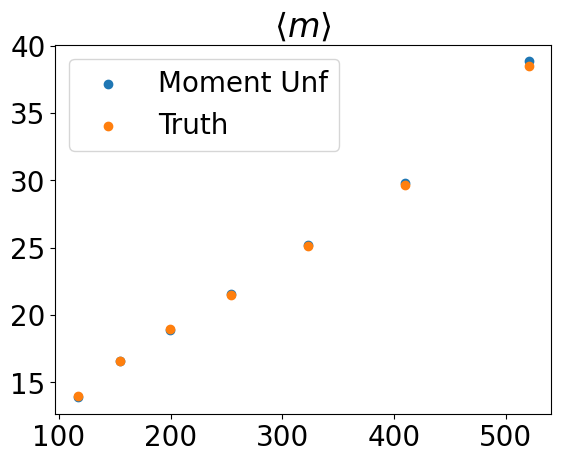

In [73]:
plt.title(r"$\langle m\rangle$")
plt.scatter(binmid, m_avgs_wg, label = "Moment Unf")
plt.scatter(binmid, m_avgs_t, label = "Truth")
plt.legend()
plt.show()

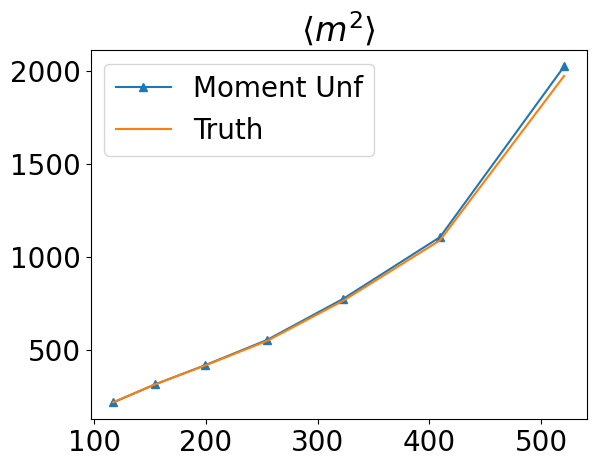

In [74]:
plt.title(r"$\langle m^2\rangle$")
plt.plot(binmid, m_var_wg, marker = "^", label = "Moment Unf")
#plt.plot(binmid, means_unbinnedx_omnifold_alt, marker = 'v', label = "Omnifold")
plt.plot(binmid, m_var_t, label = "Truth")
plt.legend()
plt.show()

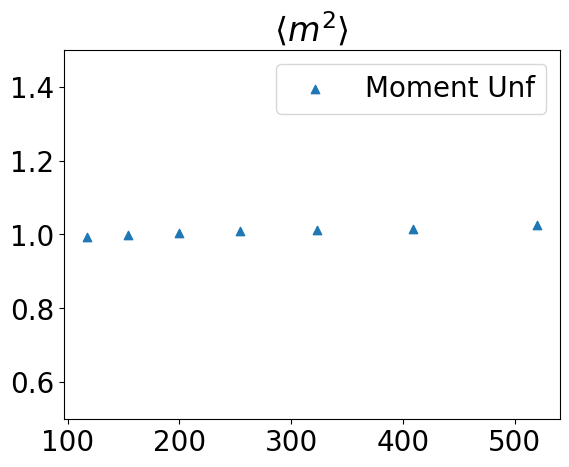

In [75]:
plt.title(r"$\langle m^2\rangle$")
plt.scatter(binmid, np.array(m_var_wg)/m_var_t, marker = "^", label = "Moment Unf")
#plt.scatter(binmid, means_unbinnedx_omnifold_alt/m_var_t, marker = 'v', label = "Omnifold")
plt.legend()
plt.ylim(.5, 1.5)
plt.show()